In [1]:
import itertools
import os
import numpy as np
import pandas as pd
import sqlite3 as sql

import matplotlib.pyplot as plt
import seaborn as sns

# Create Example Database

## Generate Data

In [2]:
# generate players
alphabet = list('abcdefghijklmnopqrstuvwxyz'*4 + 'ABCDEFGHIJKLMNOPQRSTUVWXYZ' + '0123456789')
first_names = ['Wade', 'Dave', 'Seth', 'Ivan', 'Riley', 'Gilbert', 'Jorge', 'Dan', 'Brian', 'Roberto', 
               'Ramon', 'Miles', 'Liam', 'Nathaniel', 'Ethan', 'Lewis', 'Milton', 'Claude', 'Joshua', 
               'Glen', 'Harvey', 'Blake', 'Antonio', 'Connor', 'Julian']
last_names = ['Smith', 'Johnson', 'Williams', 'Brown', 'Jones', 'Garcia', 'Miller', 'Davis', 
              'Rodriguez', 'Martinez', 'Hernandez', 'Lopez', 'Gonzalez', 'Wilson', 'Anderson', 'Thomas', 
              'Taylor', 'Moore', 'Jackson', 'Martin', 'Lee', 'Perez', 'Thompson', 'White']
n_players = 24
players = pd.DataFrame({'username' : ['@' + ''.join(np.random.choice(alphabet, 5)) for i in range(n_players)], 
                        'first_name' : np.random.choice(first_names, n_players), 
                        'last_name' : np.random.choice(last_names, n_players)})
print(f'players.shape = {players.shape}')
players.head()

players.shape = (24, 3)


,username,first_name,last_name
0,@moW3v,Roberto,Taylor
1,@cbiao,Wade,Martin
2,@DuQtp,Brian,Thomas
3,@8dFtc,Nathaniel,Anderson
4,@nDzgo,Ivan,Taylor


In [3]:
# generate playrooms (chats)
words = "Brookesia thieli Brookesia thieli, commonly known as Domergue's leaf chameleon, is a species of lizard in the chameleon family, Chamaeleonidae. The species is endemic to eastern Madagascar. It was first described in 1969 by Édouard-Raoul Brygoo and Charles Antoine Domergue. This B. thieli lizard was photographed on a leaf in Andasibe, Madagascar."
for c in ".,-'":
    words = words.replace(c, '')
words = words.split()

n_playrooms = 4
playrooms = pd.DataFrame({'id': np.arange(n_playrooms), 
                          'name': [' '.join(np.random.choice(words, 3)) for i in range(n_playrooms)]})
print(f'playrooms.shape = {playrooms.shape}')
playrooms.head()

playrooms.shape = (4, 2)


,id,name
0,0,chameleon and is
1,1,Chamaeleonidae described species
2,2,in a thieli
3,3,photographed chameleon on


In [4]:
# generate games (polls)
numbers_fascists = {5: 1, 6:1, 7:2, 8:2, 9:3, 10:3}
numbers_roles = {i: np.repeat('L', i) for i in numbers_fascists}
for i in numbers_fascists:
    numbers_roles[i][:numbers_fascists[i]] = 'F'
    numbers_roles[i][-1] = 'H'

results = ['LL', # 6 liberal laws
           'FL', # 5 fascist laws
           'HC', # Hitler is cancelor
           'HD', # Hitler died
          ]
# answers from init.sql: [HC, HD, HL, FL, LL, LW, FW], need add HW
role_and_result_answers = {('L', 'LL') : 'LW', 
                           ('L', 'HD') : 'LW', 
                           ('L', 'FL') : 'LL', 
                           ('L', 'HC') : 'LL', 
                           ('F', 'LL') : 'FL', 
                           ('F', 'HD') : 'FL', 
                           ('F', 'FL') : 'FW', 
                           ('F', 'HC') : 'FW', 
                           ('H', 'LL') : 'HL', 
                           ('H', 'HD') : 'HD', 
                           ('H', 'FL') : 'HW', 
                           ('H', 'HC') : 'HC'}

n_games = 192
polls = []
for i in range(n_games):
    number_of_players = np.random.randint(5, 11)
    poll_players = np.random.choice(players['username'], number_of_players, replace=False)
    game_result = np.random.choice(results)
    poll_answers = [role_and_result_answers[(i, game_result)] for i in numbers_roles[number_of_players]]
    np.random.shuffle(poll_answers)
    polls.append({poll_players[i] : poll_answers[i] for i in range(number_of_players)})

polls_info = pd.DataFrame({'creator' : [np.random.choice(list(poll.keys())) for poll in polls], 
                           'playroom' : np.random.choice(playrooms['name'].values, len(polls)),
                           'start_time' : np.datetime64('2019-01-01 00:00:00') + np.random.randint(10**8, size=len(polls))})
polls_info['end_time'] = polls_info['start_time'].values + np.random.randint(10**10, 10**12, size=len(polls))

print(f'polls_info.shape = {polls_info.shape}')
polls_info.head()

polls_info.shape = (192, 4)


,creator,playroom,start_time,end_time
0,@y6shw,photographed chameleon on,2021-08-25 12:30:40,2021-08-25 12:43:06.544504730
1,@cbiao,chameleon and is,2022-02-07 11:46:15,2022-02-07 12:00:24.586714928
2,@wneez,Chamaeleonidae described species,2020-03-25 17:26:19,2020-03-25 17:33:19.558434393
3,@moW3v,photographed chameleon on,2019-10-17 16:25:32,2019-10-17 16:38:19.319314608
4,@AptbG,photographed chameleon on,2019-03-20 19:22:20,2019-03-20 19:22:33.185661686


## Create DB

In [5]:
if os.path.exists("example.db"):
    os.remove("example.db")
con = sql.connect('example.db')
cur = con.cursor()

In [6]:
with open('database/init.sql', 'r') as file:
    init_query = file.read()

init_query = ''.join([query[query.find('\n')+1:] for query in init_query.split('--')])
create_queries = [query + ';' for query in init_query.split(';')]
for query in create_queries:
    cur.execute(query)

## Insert generated data

In [7]:
for i in range(len(players)):
    query = f"INSERT INTO Players(id, username, first_name, last_name) VALUES {i, players['username'].values[i], players['first_name'].values[i], players['last_name'].values[i]};"
    cur.execute(query)

In [8]:
for i in range(len(playrooms)):
    name = playrooms['name'][i]
    query = f"""INSERT INTO Playrooms(id, name) SELECT COUNT(id)+1, '{name}' AS name FROM Playrooms;"""
    cur.execute(query)

In [9]:
for i in range(len(polls)):
    # Prepare info for table Games
    creator_name, playroom_name, start_time, end_time = polls_info.values[i]
    start_time = str(start_time)[:19]
    end_time = str(end_time)[:19]
    game_id = cur.execute("""SELECT COUNT(id) FROM Games;""").fetchone()[0] + 1
    creator_id = cur.execute(f"""SELECT id FROM Players WHERE username = '{creator_name}';""").fetchone()[0]
    playroom_id = cur.execute(f"""SELECT id FROM Playrooms WHERE name = '{playroom_name}';""").fetchone()[0]
    
    poll = polls[i]
    if 'HC' in poll.values():
        game_result = "Hitler Canceler"
    if 'HW' in poll.values():
        game_result = "Fascist Law"
    if 'HD' in poll.values():
        game_result = "Hitler Death"
    if 'HL' in poll.values():
        game_result = "Liberal Law"
    
    # Insert to table Games
    query = f"""INSERT INTO Games(id, playroom_id, creator_id, start_time, end_time, result) 
                VALUES {game_id, playroom_id, creator_id, start_time, end_time, game_result};"""
    cur.execute(query)
    
    # Inserting to table Results
    for username in poll:
        role = poll[username]
        player_id = cur.execute(f"""SELECT id FROM Players WHERE username = '{username}';""").fetchone()[0]
        result_id = cur.execute("""SELECT COUNT(id) FROM Records;""").fetchone()[0] + 1
        query = f"""INSERT INTO Records(id, creator_id, player_id, playroom_id, game_id, role) 
                    VALUES {result_id, creator_id, player_id, playroom_id, game_id, role};"""
        cur.execute(query)

In [10]:
con.commit()

con = sql.connect('example.db')
cur = con.cursor()

# Different Visualisations

## Default player statistics

Here I defind given player's winrate by defferent roles.

In [11]:
def get_player_answers(cur, username):
    """
    Returns table of player with given username results grouped by his answers
    
    Parameters:
    -----------
    cur : sqlite3 cursor
        Cursor to the given database.
        
    username : string from table Players.username
        Username of given player.
    
    Returns:
    --------
    res : dict
        Keys are answers, values are count numbers
    """
    query = f"""SELECT Records.role AS answer, COUNT(*) AS count
                FROM Records
                INNER JOIN Players ON Players.id = Records.player_id
                WHERE Players.username = '{username}'
                GROUP BY Records.role;"""
    res = cur.execute(query).fetchall()
    res = {i[0] : i[1] for i in res}
    for key in ['HC', 'HD', 'HL', 'HW', 'FL', 'LL', 'LW', 'FW']:
        try:
            res[key]
        except KeyError:
            res.update({key : 0})
    return res

In [12]:
def get_player_answers(cur, username):
    """
    Returns table of player with given username results grouped by his answers
    
    Parameters:
    -----------
    cur : sqlite3 cursor
        Cursor to the given database.
        
    username : string from table Players.username
        Username of given player.
    
    Returns:
    --------
    res : dict
        Keys are answers, values are count numbers
    """
    query = f"""SELECT Records.role AS answer, COUNT(*) AS count
                FROM Records
                INNER JOIN Players ON Players.id = Records.player_id
                WHERE Players.username = '{username}'
                GROUP BY Records.role;"""
    res = cur.execute(query).fetchall()
    res = {i[0] : i[1] for i in res}
    for key in ['HC', 'HD', 'HL', 'HW', 'FL', 'LL', 'LW', 'FW']:
        try:
            res[key]
        except KeyError:
            res.update({key : 0})
    return res

In [13]:
username = players['username'].values[-1]
username

'@wneez'

In [14]:
def drow_username_winrate(cur, username, ax=None):
    """
    Plots a winrate statistics for given player.
    
    Parameters:
    -----------
    cur : sqlite3 cursor
        Cursor to the given database.
        
    username : string from table Players.username
        Username of given player.
    
    ax : matplotlib axes object, default None
        An axes of the current figure
    """
    info = get_player_answers(cur, username)
    bins = pd.DataFrame([[info['LW'], info['LL']], 
                         [info['FW'], info['FL']], 
                         [info['HC'] + info['HW'], info['HD'] + info['HL']]], 
                        columns=['Wins', 'Loses'], 
                        index=['Liberal', 'Fascist', 'Hitler']).transpose()
    
    bins.plot(kind='bar', stacked=True, color=['deepskyblue', 'orangered', 'darkred'], rot='horizontal', ax=ax)

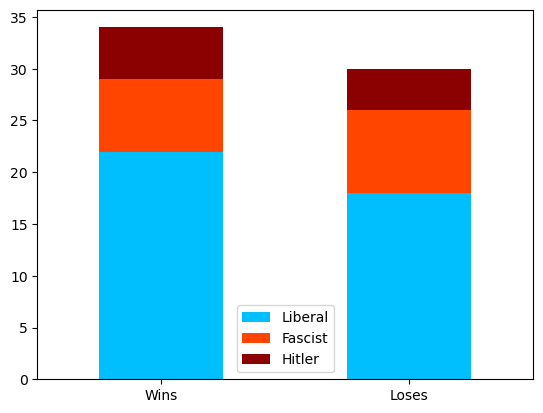

In [15]:
drow_username_winrate(cur, username)

## Best&worst teammates&opponents

Hare I try to define functions drowing stats with best and worst teammates opponents

In [16]:
def get_teammate_stats(cur, username):
    """
    Returns table of counts wins and loses in both teames for each player's teammate
    
    Parameters:
    ------
    cur : sqlite3 cursor
        Cursor to the given database.
        
    username : string from table Players.username
        Username of given player.
        
    Retuens:
    --------
    res : DataFrame
        Indexes are usernames,
        Columns are team and win stasuses
    """
    query = f"""WITH w1(record_id, game_id, player_id, win, liberal) AS 
                (SELECT id, game_id, player_id, role IN ('HC', 'HW', 'FW', 'LW'), role IN ('LL', 'LW') FROM records), 
                w2(game_id, player_liberal) AS 
                (SELECT records.game_id, records.role IN ('LL', 'LW') FROM records 
                INNER JOIN players ON players.id = records.player_id WHERE players.username="{username}")
                SELECT players.username,
                SUM(CASE WHEN w1.win AND w1.liberal THEN 1 ELSE 0 END) AS LW, 
                SUM(CASE WHEN w1.win AND NOT w1.liberal THEN 1 ELSE 0 END) AS FW, 
                SUM(CASE WHEN NOT w1.win AND w1.liberal THEN 1 ELSE 0 END) AS LL, 
                SUM(CASE WHEN NOT w1.win AND NOT w1.liberal THEN 1 ELSE 0 END) AS FL FROM w1
                INNER JOIN w2 ON w1.game_id = w2.game_id
                INNER JOIN players ON w1.player_id = players.id
                WHERE players.username != "{username}" AND w1.liberal = w2.player_liberal
                GROUP BY player_id;"""
    res = cur.execute(query).fetchall()
    res = pd.DataFrame(res, columns=['username', 'LW', 'FW', 'LL', 'FL'])
    return res

In [17]:
df = get_teammate_stats(cur, username)
df['Total'] = df[['LW', 'FW', 'LL', 'FL']].sum(axis=1)
df['Winrate'] = (df['LW'] + df['FW']) / df['Total']
df = df.sort_values(by=['Winrate', 'Total'], ascending=False)
df

,username,LW,FW,LL,FL,Total,Winrate
0,@moW3v,7,2,1,0,10,0.900000
5,@8fqhT,2,3,1,0,6,0.833333
6,@m9Tab,5,0,1,1,7,0.714286
17,@fjbHc,4,1,2,0,7,0.714286
21,@twlbl,5,2,1,2,10,0.700000
14,@aabjs,5,2,3,1,11,0.636364
3,@8dFtc,5,1,2,2,10,0.600000
12,@dIecn,5,1,4,0,10,0.600000
16,@qkuky,6,0,1,3,10,0.600000
1,@cbiao,3,1,1,2,7,0.571429


In [18]:
def get_opponent_stats(cur, username):
    """
    Returns table of counts wins and loses in both opponent for each player's teammate
    
    Parameters:
    ------
    cur : sqlite3 cursor
        Cursor to the given database.
        
    username : string from table Players.username
        Username of given player.
        
    Retuens:
    --------
    res : DataFrame
        Indexes are usernames,
        Columns are team and win stasuses
    """
    query = f"""WITH w1(record_id, game_id, player_id, win, liberal) AS 
                (SELECT id, game_id, player_id, role IN ('HC', 'HW', 'FW', 'LW'), role IN ('LL', 'LW') FROM records), 
                w2(game_id, player_liberal) AS 
                (SELECT records.game_id, records.role IN ('LL', 'LW') FROM records 
                INNER JOIN players ON players.id = records.player_id WHERE players.username="{username}")
                SELECT players.username,
                SUM(CASE WHEN w1.win AND w1.liberal THEN 1 ELSE 0 END) AS LW, 
                SUM(CASE WHEN w1.win AND NOT w1.liberal THEN 1 ELSE 0 END) AS FW, 
                SUM(CASE WHEN NOT w1.win AND w1.liberal THEN 1 ELSE 0 END) AS LL, 
                SUM(CASE WHEN NOT w1.win AND NOT w1.liberal THEN 1 ELSE 0 END) AS FL FROM w1
                INNER JOIN w2 ON w1.game_id = w2.game_id
                INNER JOIN players ON w1.player_id = players.id
                WHERE players.username != "{username}" AND w1.liberal != w2.player_liberal
                GROUP BY player_id;"""
    res = cur.execute(query).fetchall()
    res = pd.DataFrame(res, columns=['username', 'LW', 'FW', 'LL', 'FL'])
    return res

In [19]:
df = get_opponent_stats(cur, username)
df['Total'] = df[['LW', 'FW', 'LL', 'FL']].sum(axis=1)
df['Winrate'] = (df['LW'] + df['FW']) / df['Total']
df = df.sort_values(by=['Winrate', 'Total'], ascending=False)
df

,username,LW,FW,LL,FL,Total,Winrate
9,@jfbjt,2,6,2,1,11,0.727273
4,@nDzgo,2,4,0,3,9,0.666667
20,@y6shw,4,4,1,5,14,0.571429
22,@AptbG,3,5,2,4,14,0.571429
0,@moW3v,1,4,4,0,9,0.555556
1,@cbiao,1,4,1,3,9,0.555556
6,@m9Tab,3,3,3,2,11,0.545455
15,@4JWl4,4,2,3,2,11,0.545455
19,@xhNph,4,2,3,2,11,0.545455
11,@5pedv,2,2,2,2,8,0.500000
